<a href="https://colab.research.google.com/github/Sg0107/CNN/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
import os

# Specify the path to the zip file
zip_file_path = "/content/drive/MyDrive/Files.zip"

# Specify the directory where you want to extract the contents
extracted_dir = "/content/drive/MyDrive/W2A2"

# Create the target directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Files extracted to: {extracted_dir}")


Files extracted to: /content/drive/MyDrive/W2A2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)
directory = "/content/drive/MyDrive/W2A2/Files/home/jovyan/work/W2A2/dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             validation_split = 0.2,
                                             subset = 'training',
                                             seed = 42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             validation_split = 0.2,
                                             subset = 'validation',
                                             seed = 42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


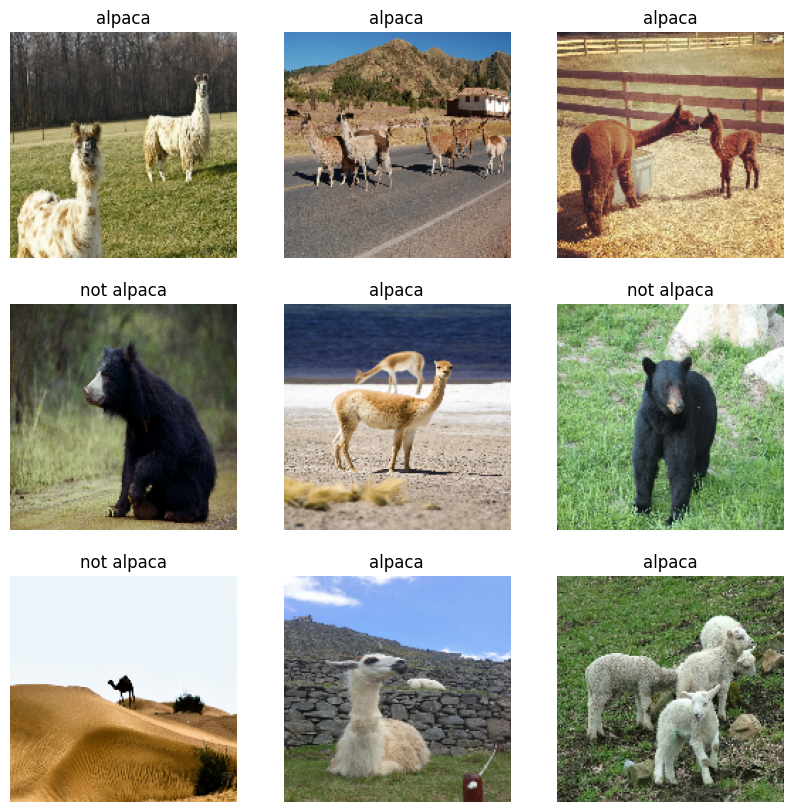

In [6]:

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")
plt.show()


<font color = 'Red'>**2 - Preprocess and Augment Training Data**

<font color = 'Blue'>You may have encountered dataset.prefetch in a previous TensorFlow assignment, as an important extra step in data preprocessing.

<font color = 'blue'>Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

<font color = 'blue'>You can set the number of elements to prefetch manually, or you can use tf.data.experimental.AUTOTUNE to choose the parameters automatically. Autotune prompts tf.data to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

<font color = 'blue'>To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later. Ahh, so convenient!

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [20]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential([
      RandomFlip("horizontal"),
      RandomRotation(0.2)
  ])
  return data_augmentation

In [21]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


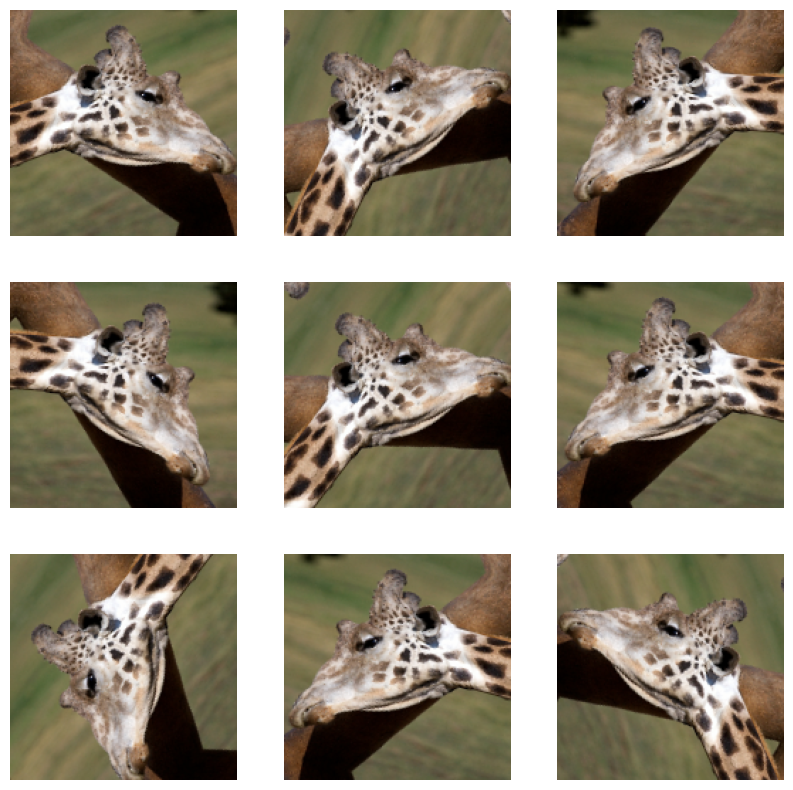

In [22]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

<font color = 'blue'>**What you should remember:**
* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = True,
                                               weights = 'imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [34]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers-2].name)
print(base_model.layers[nb_layers-1].name)

global_average_pooling2d
predictions


<font color='blue'>**What you should remember**:

* MobileNetV2's unique features are:
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [35]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [36]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [38]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(),top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329976),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883594)],
 [('n02125311', 'cougar', 0.16546734), ('n02389026', 'sorrel', 0.107642956)],
 [('n02437312', 'Arabian_camel', 0.2923277),
  ('n02437616', 'llama', 0.2771352)],
 [('n03944341', 'pinwheel', 0.31154993), ('n03047690', 'clog', 0.052499976)],
 [('n02454379', 'armadillo', 0.73107195),
  ('n01990800', 'isopod', 0.038719796)],
 [('n02437312', 'Arabian_camel', 0.2566362),
  ('n02422106', 'hartebeest', 0.12122769)],
 [('n02437616', 'llama', 0.6612558),
  ('n02090721', 'Irish_wolfhound', 0.23782833)],
 [('n02133161', 'American_black_bear', 0.8273561),
  ('n02134418', 'sloth_bear', 0.029259538)],
 [('n01518878', 'ostrich', 0.9267558),
  ('n02002724', 'black_stork', 0.0017766341)],
 [('n01518878', 'ostrich', 0.9495457), ('n02018795', 'bustard', 0.0028661576)],
 [('n02437616', 'llama', 0.8699817), ('n02412080', 'ram', 0.07675809)],
 [('n02415577', 'bighorn', 0.24294557), ('n02412080', 'ram', 0.1

In [40]:
def alpaca_model(image_shape = IMG_SIZE, data_augmentation=data_augmenter):
  IMG_SHAPE = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x=data_augmentation(inputs)
  x = preprocess_input(x)
  x=base_model(x,training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1,activation='linear')(x)
  model = tf.keras.Model(inputs,outputs)
  return model

In [41]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from drive.MyDrive.W2A2.Files.home.jovyan.work.W2A2.test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)


In [45]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 22s 1s/step - loss: 0.8534 - accuracy: 0.4847 - val_loss: 0.7346 - val_accuracy: 0.5077
Epoch 2/5
9/9 [==============================] - 15s 1s/step - loss: 0.7403 - accuracy: 0.5382 - val_loss: 0.5887 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 11s 808ms/step - loss: 0.5941 - accuracy: 0.6756 - val_loss: 0.4728 - val_accuracy: 0.6462
Epoch 4/5
9/9 [==============================] - 10s 853ms/step - loss: 0.4873 - accuracy: 0.7443 - val_loss: 0.4771 - val_accuracy: 0.6000
Epoch 5/5
9/9 [==============================] - 12s 879ms/step - loss: 0.4666 - accuracy: 0.7519 - val_loss: 0.3933 - val_accuracy: 0.6769


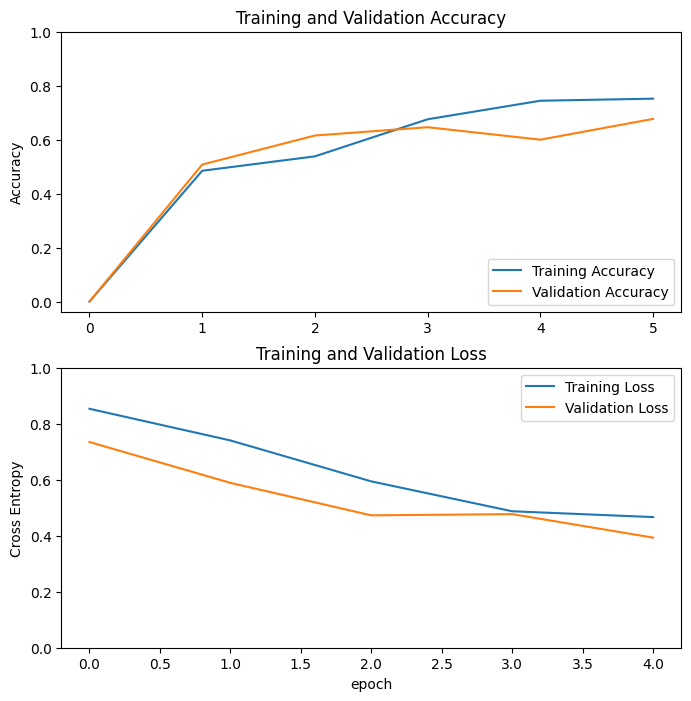

In [47]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
class_names

['alpaca', 'not alpaca']

In [51]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [52]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 22s 1s/step - loss: 0.6498 - accuracy: 0.6794 - val_loss: 0.2533 - val_accuracy: 0.9538
Epoch 6/10
9/9 [==============================] - 11s 953ms/step - loss: 0.4325 - accuracy: 0.7748 - val_loss: 0.2411 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 12s 1s/step - loss: 0.3076 - accuracy: 0.8740 - val_loss: 0.2283 - val_accuracy: 0.8000
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.2418 - accuracy: 0.8740 - val_loss: 0.1214 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.1729 - accuracy: 0.9160 - val_loss: 0.0945 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 12s 918ms/step - loss: 0.1482 - accuracy: 0.9542 - val_loss: 0.0772 - val_accuracy: 0.9846


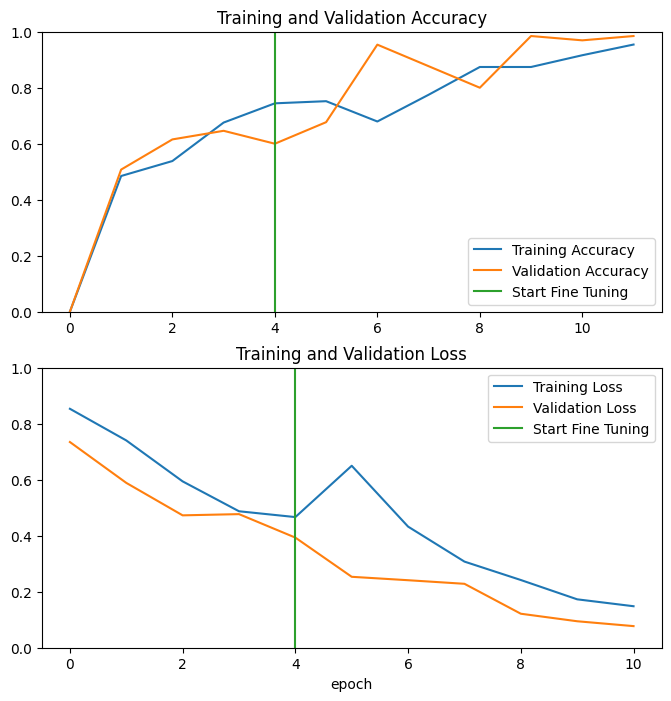

In [53]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy